In [1]:
import pandas as pd
import numpy as np
import argparse
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.ticker as mticker
from matplotlib.offsetbox import AnchoredText
import os
from numpy import linalg 

In [2]:
# an auxiliary function to compute the projection of a point on a line
# p1 and p2 define a line and the function aims to find a point p4 on the line that is closest to p3
def get_closet_point_in_line(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    dx, dy = x2 - x1, y2 - y1
    det = dx * dx + dy * dy
    a = (dy * (y3 - y1) + dx * (x3 - x1)) / det
    return x1 + a * dx, y1 + a * dy

#  Read PAP data

In [5]:
df_pap = pd.read_csv("Example2_micafungin_Cpara_SIAT/input_pap.csv", index_col=0)
df_pap

,17H1663,16RT032,16RT037,17RT046,17TJ01008,18H1744,19DL329,19Hb04-021,19JL02143,19TJ01-029,...,19Y2 282,15GF053,15HD046,19HD197,15GH496,14Z1230,16AS086,16AS065,16AS081,15JS412
strain,,,,,,,,,,,,,,,,,,,,,
0,100.000000,100.000000,100.000000,100.000000,100,100.000000,100,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100,100.000000,100,100,100,100.000000,100.000000
1,0.001951,0.012086,0.000479,0.004127,0,0.005835,0,0.000606,0.010224,0.000435,...,0.007558,0.000474,0.000235,0,0.000303,0,0,0,0.001043,0.000509
2,0.000000,0.000000,0.000000,0.002874,0,0.001328,0,0.000000,0.000179,0.000000,...,0.000116,0.000000,0.000000,0,0.000303,0,0,0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.001003,0,0.000724,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0,0,0,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000368,0,0.001247,0,0.000000,0.000000,0.000000,...,0.000000,0.000079,0.000000,0,0.000000,0,0,0,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000251,0,0.000684,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0,0,0,0.000000,0.000000
32,0.000000,0.000000,0.000000,0.000852,0,0.001127,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0,0.000000,0,0,0,0.000000,0.000000


In [15]:
df_pap.stack().reset_index()[df_pap.stack().reset_index()[0]>0][0].min()

5.074854097944684e-08

In [153]:
df_pap.stack().reset_index()

,Strain_No,strain,0
0,0,17H1663,10.0
1,0,16RT032,10.0
2,0,16RT037,10.0
3,0,17RT046,10.0
4,0,17TJ01008,10.0
...,...,...,...
534,32,14Z1230,0.0
535,32,16AS086,0.0
536,32,16AS065,0.0
537,32,16AS081,0.0


In [156]:
np.linspace(-10,-1,10)

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

In [16]:
dol=1e-8

In [17]:
df_pap = np.log10(df_pap).replace(-np.inf, np.log10(dol)) - np.log10(dol)
df_pap

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


,17H1663,16RT032,16RT037,17RT046,17TJ01008,18H1744,19DL329,19Hb04-021,19JL02143,19TJ01-029,...,19Y2 282,15GF053,15HD046,19HD197,15GH496,14Z1230,16AS086,16AS065,16AS081,15JS412
Strain_No,,,,,,,,,,,,,,,,,,,,,
0,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.0,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.0,10.000000,10.0,10.0,10.0,10.000000,10.000000
1,3.290306,4.082294,2.680559,3.615633,0.0,3.766042,0.0,2.782516,4.009630,2.638272,...,3.878415,2.676061,2.370275,0.0,2.481486,0.0,0.0,0.0,3.018483,2.707101
2,0.000000,0.000000,0.000000,3.458464,0.0,3.123188,0.0,0.000000,2.253755,0.000000,...,2.065502,0.000000,0.000000,0.0,2.481486,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,3.001087,0.0,2.859946,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
8,0.000000,0.000000,0.000000,2.565359,0.0,3.096035,0.0,0.000000,0.000000,0.000000,...,0.000000,1.897909,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
16,0.000000,0.000000,0.000000,2.399027,0.0,2.835123,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
32,0.000000,0.000000,0.000000,2.930506,0.0,3.051832,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


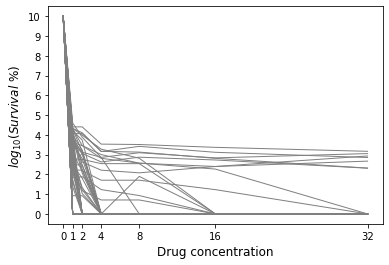

In [41]:
fig, ax00 = plt.subplots(figsize=(6,4))
for strain in df_pap.columns:
    _ = ax00.plot(df_pap.index, df_pap[strain], linewidth=1, color='Gray')
_ = ax00.set_xlabel('Drug concentration', fontsize=12)
_ = ax00.set_ylabel('$log_{10}(Survival~\%)$', fontsize=12)
_ = ax00.set_xticks(list(df_pap.index))
_ = ax00.set_ylim([-0.5, 10.5])
_ = ax00.set_yticks(np.arange(0, 11))

# run non-negative matrix factorization

In [141]:
df_pap_t = df_pap.T
try:
    model = NMF(n_components=2, init='nndsvdar', random_state=42, max_iter=100000, tol=1e-6, alpha_W=1e-3, alpha_H=1e-3)
except RuntimeWarning:
    print('asd')
df_pap_W = pd.DataFrame(model.fit_transform(df_pap_t.values), columns=['Factor1', 'Factor2'], index=df_pap_t.index)
df_pap_W.index.name = 'strain'
df_pap_H = pd.DataFrame(model.components_, columns=df_pap.index, index=['Basis1', 'Basis2'])

In [142]:
model.n_iter_

7915

In [143]:
df_pap_H

Strain_No,0,1,2,4,8,16,32
Basis1,4.896706,0.714503,0.000696,0.000000,0.000000,0.000000,0.000000
Basis2,1.323486,1.439161,1.530613,0.920601,0.853955,0.664942,0.571945


# plot reconstruction error by changing alpha

In [118]:
r2_sum = []
for a in [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]: 
    print(a)
    df_pap_t = df_pap.T
    model = NMF(n_components=2, init='nndsvdar', random_state=42, max_iter=1000000, tol=1e-6, alpha_W=a, alpha_H=a)
    df_pap_W = pd.DataFrame(model.fit_transform(df_pap_t.values), columns=['Factor1', 'Factor2'], index=df_pap_t.index)
    df_pap_W.index.name = 'strain'
    df_pap_H = pd.DataFrame(model.components_, columns=df_pap.index, index=['Basis1', 'Basis2'])
    obj = model.reconstruction_err_ + 0.5*a*(len(df_pap_t.columns)*linalg.norm(df_pap_W) + len(df_pap_t.index)*linalg.norm(df_pap_H))
    print(df_pap_H)
    
    res = []
    for strain in df_pap_W.index:
        pap_obs = df_pap[strain]
        pap_pred = df_pap_W.loc[strain, 'Factor1'] * df_pap_H.loc['Basis1', :] + \
                   df_pap_W.loc[strain, 'Factor2'] * df_pap_H.loc['Basis2', :]
        for conc, obs, pred in zip(list(df_pap.index), pap_obs, pap_pred):
            res.append([strain, conc, obs, pred])
    df_recon = pd.DataFrame(res, columns=['strain', 'drug_conc', 'obs', 'pred'])
    df_recon['drug_conc'] = df_recon['drug_conc'].astype(str)
    r2 = r2_score(y_true=df_recon['obs'], y_pred=df_recon['pred'])
    r2_sum.append([a, r2, model.reconstruction_err_, obj])
df_r2_sum = pd.DataFrame(r2_sum, columns=['alpha','r2','REerr','OBJ'])
df_r2_sum

0
Strain_No        0         1         2         4         8        16       32
Basis1     9.434114  1.376186  0.000655  0.000000  0.000000  0.00000  0.00000
Basis2     0.000000  2.807538  3.448992  2.074233  1.924058  1.49822  1.28869
1e-10
Strain_No        0         1         2         4         8        16       32
Basis1     9.434114  1.376186  0.000655  0.000000  0.000000  0.00000  0.00000
Basis2     0.000000  2.807538  3.448992  2.074233  1.924057  1.49822  1.28869
1e-09
Strain_No        0         1         2         4         8        16       32
Basis1     9.434113  1.376186  0.000655  0.000000  0.000000  0.00000  0.00000
Basis2     0.000000  2.807537  3.448991  2.074233  1.924057  1.49822  1.28869
1e-08
Strain_No        0         1         2         4         8         16  \
Basis1     9.434109  1.376186  0.000656  0.000000  0.000000  0.000000   
Basis2     0.000000  2.807530  3.448983  2.074229  1.924053  1.498217   

Strain_No        32  
Basis1     0.000000  
Basis2     1.2

KeyboardInterrupt: 

# normalize W and H matrices

In [144]:
shifted_max_log10_pap = 2 - np.log10(dol)
multiplier = [shifted_max_log10_pap / v for v in list(df_pap_H[0])]
df_pap_H.iloc[0, :] = df_pap_H.iloc[0, :] * multiplier[0]
df_pap_H.iloc[1, :] = df_pap_H.iloc[1, :] * multiplier[1]
df_pap_W.iloc[:, 0] = df_pap_W.iloc[:, 0] / multiplier[0]
df_pap_W.iloc[:, 1] = df_pap_W.iloc[:, 1] / multiplier[1]

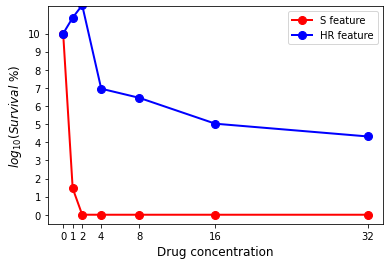

In [146]:
fig, ax01 = plt.subplots(figsize=(6,4))

basis1_feature = 'S'
basis2_feature = 'HR'
if np.mean(df_pap_H.loc['Basis1', :]) > np.mean(df_pap_H.loc['Basis2', :]):
    basis1_feature = 'HR'
    basis2_feature = 'S'
_ = ax01.plot(df_pap.index, df_pap_H.loc['Basis1', :], 'ro-', linewidth=2, markersize=8,
              label='%s feature' % basis1_feature)
_ = ax01.plot(df_pap.index, df_pap_H.loc['Basis2', :], 'bo-', linewidth=2, markersize=8,
              label='%s feature' % basis2_feature)
_ = ax01.legend()
_ = ax01.set_xlabel('Drug concentration', fontsize=12)
_ = ax01.set_ylabel('$log_{10}(Survival ~\%)$', fontsize=12)
_ = ax01.set_ylim([-0.5, 11.5])
_ = ax01.set_yticks(np.arange(0, 11))
_ = ax01.set_xticks(list(df_pap.index))

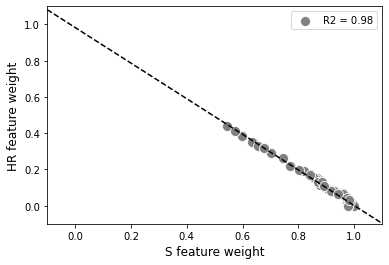

In [147]:
fig, ax02 = plt.subplots(figsize=(6,4))

regression = stats.linregress(df_pap_W.Factor1, df_pap_W.Factor2)
_ = sns.scatterplot(x='Factor1', y='Factor2', data=df_pap_W, color='gray', marker='o', s=100, ax=ax02,
                    label='R2 = %2.2f' % (regression.rvalue ** 2))
_ = ax02.legend()
xdense = np.linspace(-0.1, 1.1, 100)
ydense = regression.intercept + regression.slope * xdense
_ = ax02.plot(xdense, ydense, 'k--')
_ = ax02.set_xlabel("%s feature weight" % basis1_feature, fontsize=12)
_ = ax02.set_ylabel('%s feature weight' % basis2_feature, fontsize=12)
_ = ax02.set_xlim([-0.1, 1.1])
_ = ax02.set_ylim([-0.1, 1.1])
_ = ax02.legend()

In [148]:
# compute hetero-resistance index by projecting all weights (W) on x+y=1
res = []
for strain in df_pap_W.index:
    projection = get_closet_point_in_line((0, 1), (1, 0),
                                          (df_pap_W.loc[strain, 'Factor1'], df_pap_W.loc[strain, 'Factor2']))
    hr_index = projection[0]
    if hr_index < 0:
        warnings.warn("Hetero-resistance index < 0 for %s. its value (%2.2f) is round to 0.0." % (strain, hr_index))
        hr_index = 0
    if hr_index > 1:
        warnings.warn("Hetero-resistance index > 1 for %s. its value (%2.2f) is round to 1.0" % (strain, hr_index))
        hr_index = 1
    res.append(hr_index)
df_hr = pd.DataFrame(res, columns=['HR_INDEX'], index=df_pap_W.index).sort_values('HR_INDEX')

In [149]:
df_hr

,HR_INDEX
strain,
19HX1338,0.552058
19XY447,0.581483
19HX1344,0.605479
18H1744,0.641356
17RT046,0.648305
...,...
16GY026,0.989436
17CH228,0.989436
13JX024,0.994168
